In [1]:
import boto3
from IPython.display import display
import json
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool
import os
import numpy as np
import pickle
from PIL import Image
import random
import sagemaker
from sklearn.model_selection import train_test_split
import ssl
import tarfile
import tensorflow as tf
from tqdm import tqdm
import urllib.request

In [2]:
## set s3 bucket
sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()

In [3]:
## download cinic 10 dataset
# https://datashare.is.ed.ac.uk/handle/10283/3192

# download progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    ssl._create_default_https_context = ssl._create_unverified_context
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)
        

# set up and start download
cinic_filename = 'CINIC-10.tar.gz'
cinic_download_url = 'https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/' + cinic_filename
local_data_folder = '../data'
cinic_extracted_folder = 'cinic-10'

os.makedirs(local_data_folder, exist_ok=True)
download_url(cinic_download_url, local_data_folder +'/'+ cinic_filename)

CINIC-10.tar.gz: 688MB [25:46, 445kB/s]                                


In [4]:
## extract files
extracted_path = local_data_folder + '/' + cinic_extracted_folder
tarfile.open(os.path.join(local_data_folder, cinic_filename), 'r:gz').extractall(extracted_path)

In [5]:
## train/validation/test split
# load file names
image_files = [os.path.join(r,file) for r,d,f in os.walk(extracted_path) for file in f if file.endswith('.png')]

# shuffle and split
train_filenames, validation_test_filenames = train_test_split(
    image_files, train_size=0.8, test_size=0.2, random_state=24601)
validation_filenames, test_filenames = train_test_split(
    validation_test_filenames, train_size=0.5, test_size=0.5, random_state=24601)

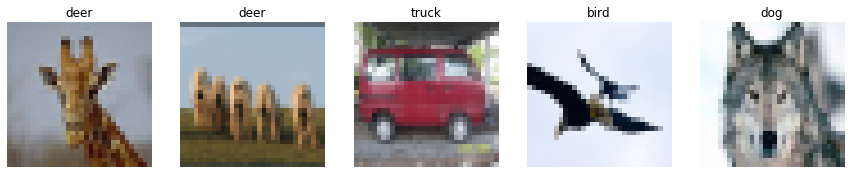

In [6]:
## visualize CINIC-10 data

# plot the first 5 samples in test
fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    
    # parse label
    label = train_filenames[i].split('/')[-2]

    # load and plot image
    image = Image.open(train_filenames[i])
    image_np = np.asarray(image)
    ax[i].set_axis_off()
    ax[i].imshow(image_np)
    ax[i].set_title(label)

In [7]:
## create label dictionary
all_labels = [filename.split('/')[-2] for filename in image_files]
all_labels = sorted(list(set(all_labels)))
label_dictionary = {k:v for k,v in zip(all_labels, range(0,len(all_labels)))}
inverted_label_dictionary = {v:k for k,v in label_dictionary.items()}

label_dictionary_json = json.dumps(label_dictionary)
with open("../data/label_dictionary.json", "w") as f:
    f.write(label_dictionary_json)
    
inverted_label_dictionary_json = json.dumps(inverted_label_dictionary)
with open("../data/inverted_label_dictionary.json", "w") as f:
    f.write(inverted_label_dictionary_json)

print(inverted_label_dictionary)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [8]:
## helper functions to build the tfrecords protocol buffer
# https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [9]:
## functions to shard and convert to tfrecords

# function to build the tfrecord file
def create_tfrecords_in_shards(data_filenames, record_index, dataset_name):
    
    # set up paths
    output_path = '../data/sharded_tfrecords/{}'.format(dataset_name)
    output_file = '{}/{}_{:03d}.tfrecords'.format(output_path, dataset_name, record_index)
    os.makedirs(output_path, exist_ok=True)
    
    # set up tfrecord writer
    number_of_samples_written = 0
    with tf.io.TFRecordWriter(output_file) as record_writer:

        # write each entry to tfrecord
        num_entries_in_batch = len(data_filenames)
        for input_file in data_filenames:
            # load label and image
            label_str = input_file.split('/')[-2]
            label_int = label_dictionary[label_str]
            image = Image.open(input_file).convert('RGB')
            image_np = np.asarray(image)
            
            # encode and write to tfrecord
            example = tf.train.Example(features=tf.train.Features(
                feature={
                    'image': _bytes_feature(image_np.tobytes()),
                    'label': _int64_feature(label_int)
                }))
            record_writer.write(example.SerializeToString())
            number_of_samples_written += 1

    return number_of_samples_written, output_file


# multiprocessing wrapper function
def multi_create_tfrecords_in_shards(data_filenames, dataset_name, num_files_to_create, num_workers):
    
    # split up arguments to shard
    split_data_filenames = np.array_split(data_filenames, num_files_to_create)
    tfrecord_args = zip(split_data_filenames, range(0, num_files_to_create), [dataset_name]*num_files_to_create)

    # create the shards
    with Pool(processes=num_workers) as pool:
        tfrecords_func_output = pool.starmap(create_tfrecords_in_shards, tfrecord_args)
    sample_counts = [x[0] for x in tfrecords_func_output]
    output_files = [x[1] for x in tfrecords_func_output]
    
    return sum(sample_counts), output_files

In [10]:
## create tfrecords for train, validation and test set

num_files_to_create = 96 # some multiple of 8 as we will use 8 GPUs
num_workers = cpu_count()-1

num_train_samples, train_tfrecords = multi_create_tfrecords_in_shards(
    data_filenames=train_filenames,
    dataset_name='train',
    num_files_to_create=num_files_to_create,
    num_workers=num_workers,)

num_validation_samples, validation_tfrecords = multi_create_tfrecords_in_shards(
    data_filenames=validation_filenames,
    dataset_name='validation',
    num_files_to_create=num_files_to_create,
    num_workers=num_workers,)

num_test_samples, test_tfrecords = multi_create_tfrecords_in_shards(
    data_filenames=test_filenames,
    dataset_name='test',
    num_files_to_create=num_files_to_create,
    num_workers=num_workers,)

In [11]:
print("Wrote {} samples in the train set.".format(num_train_samples))
print("Wrote {} samples in the validation set.".format(num_validation_samples))
print("Wrote {} samples in the test set.".format(num_test_samples))

Wrote 216000 samples in the train set.
Wrote 27000 samples in the validation set.
Wrote 27000 samples in the test set.


In [12]:
## parse and confirm data in tfrecords

# load and test the tf record files
dataset = tf.data.TFRecordDataset(train_tfrecords)

# Create a dictionary describing the features.
sample_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_sample_function(example_proto):
    return tf.io.parse_single_example(example_proto, sample_feature_description)

parsed_sample_dataset = dataset.map(_parse_sample_function)

for i, sample_features in enumerate(parsed_sample_dataset):
    image = tf.io.decode_raw(sample_features['image'], tf.uint8)
    image = tf.reshape(image, (32,32,3))
    
    label = sample_features['label']
    
    if i==1000: break

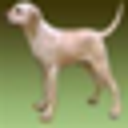

dog


In [13]:
display(Image.fromarray(image.numpy()).resize((128,128)))
print(inverted_label_dictionary[label.numpy()])

In [14]:
## count number of samples in tfrecords

train_path = f'{local_data_folder}/sharded_tfrecords/train/'
files = [os.path.join(r,file) for r,d,f in os.walk(train_path) for file in f]
dataset = tf.data.TFRecordDataset(files)
num_train_samples = sum(1 for _ in dataset)
print("Counted {} samples in train set.".format(num_train_samples))

validation_path = f'{local_data_folder}/sharded_tfrecords/validation/'
files = [os.path.join(r,file) for r,d,f in os.walk(validation_path) for file in f]
dataset = tf.data.TFRecordDataset(files)
num_validation_samples = sum(1 for _ in dataset)
print("Counted {} samples in validation set.".format(num_validation_samples))

test_path = f'{local_data_folder}/sharded_tfrecords/test/'
files = [os.path.join(r,file) for r,d,f in os.walk(test_path) for file in f]
dataset = tf.data.TFRecordDataset(files)
num_test_samples = sum(1 for _ in dataset)
print("Counted {} samples in test set.".format(num_test_samples))

Counted 216000 samples in train set.
Counted 27000 samples in validation set.
Counted 27000 samples in test set.


In [15]:
## upload to s3
for dataset in ['train', 'validation', 'test']:
    prefix = 'distributed_training_demo/data/' + dataset
    !aws s3 cp ../data/sharded_tfrecords/{dataset} s3://{bucket}/{prefix} --recursive --quiet